In [69]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [70]:
#numeric libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import griddata

#visualization
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# **Data input and visualization**

In [71]:
df = pd.read_csv("/content/hodograph.csv", sep=',', header=0)

In [72]:
# Assuming X, Y, Z are your original arrays
points = np.array([X.ravel(), Y.ravel()]).T
values = Z.ravel()

# Create new grid
xnew = np.linspace(X.min(), X.max(), 1100)
ynew = np.linspace(Y.min(), Y.max(), 1100)
Xnew, Ynew = np.meshgrid(xnew, ynew)
points_new = np.array([Xnew.ravel(), Ynew.ravel()]).T

# Interpolate data on the new grid
Znew = griddata(points, values, points_new, method='cubic')
Znew = Znew.reshape((1100, 1100))

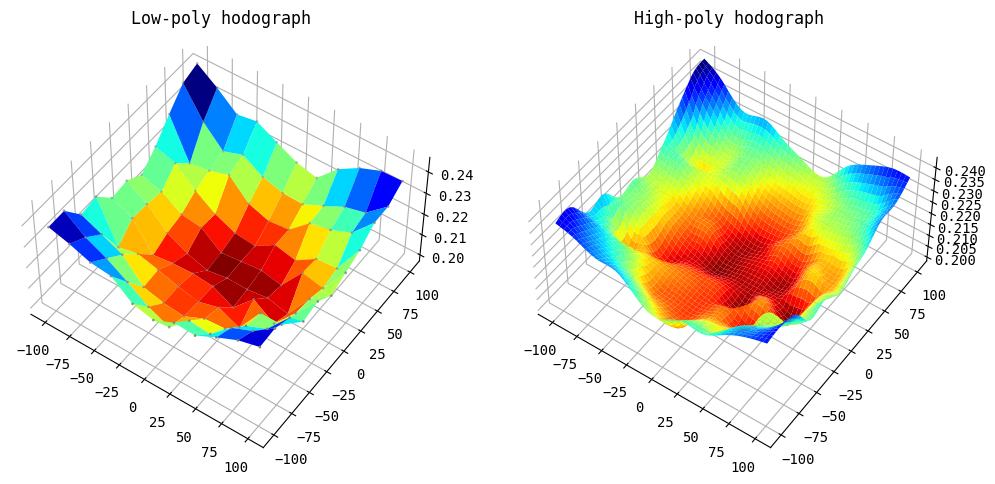

In [73]:
plt.rcParams["font.family"] = "monospace"

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.set_box_aspect(aspect = (2.5,2.5,1.4))
ax.view_init(elev=50., azim=-55)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

X = np.array(df["rec_x"]).reshape(11, 11)
Y = np.array(df["rec_y"]).reshape(11, 11)
Z = np.array(df["time"]).reshape(11, 11)

ax.plot_surface(X, Y, Z, cmap = "jet_r")
ax.scatter3D(df["rec_x"], df["rec_y"], df["time"], color = "gray", s = 1)

plt.title("Low-poly hodograph")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_box_aspect(aspect = (2.5,2.5,1.4))
ax2.view_init(elev=50., azim=-55)

ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax2.xaxis.pane.set_edgecolor('w')
ax2.yaxis.pane.set_edgecolor('w')
ax2.zaxis.pane.set_edgecolor('w')

# Creating plot
ax2.plot_surface(Xnew, Ynew, Znew, cmap = "jet_r")
# ax.scatter3D(df["rec_x"], df["rec_y"], znew, color = "gray", s = 1)

plt.title("High-poly hodograph")

plt.show()

# **Scipy-based decision**

Final equation seems like this:

$$
t = \sqrt{{t_0^2 + \frac{{x^2+y^2}}{{v^2}}}}
$$


In [74]:
# Loss function
def residuals(params: list, x, y, t_measured) -> float:
    try:
        t0, velocity = params
        t_calculated = np.sqrt(t0**2 + (x**2+y**2)/(velocity**2))

        return np.linalg.norm(t_measured - t_calculated, ord= 2)

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Void callback function for scipy.optimize.minimize
def callback(params: list):
    try:
        global residuals_history, params_history
        residuals_history.append(residuals(params, x, y, t_measured))
        params_history.append(params.copy())
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [75]:
# Initial guess for t0 and velocity
initial_guess = [0, 600]
bounds = ((0, None), (0, None))
residuals_history = []
params_history = []

x = np.array(df["rec_x"])
y = np.array(df["rec_y"])
t_measured = np.array(df["time"])

# Call the optimizer
result = minimize(fun = residuals,
                  x0 = initial_guess,
                  args=(x, y, t_measured),
                  tol = 1e-10,
                  bounds = bounds,
                  method = "l-bfgs-b",
                  options={'disp': True},
                  callback = callback
                 )


# The optimal parameters are in result.x
t0_opt, velocity_opt = result.x

In [76]:
t0_opt, velocity_opt

(0.20061429286259316, 1038.0619415971241)

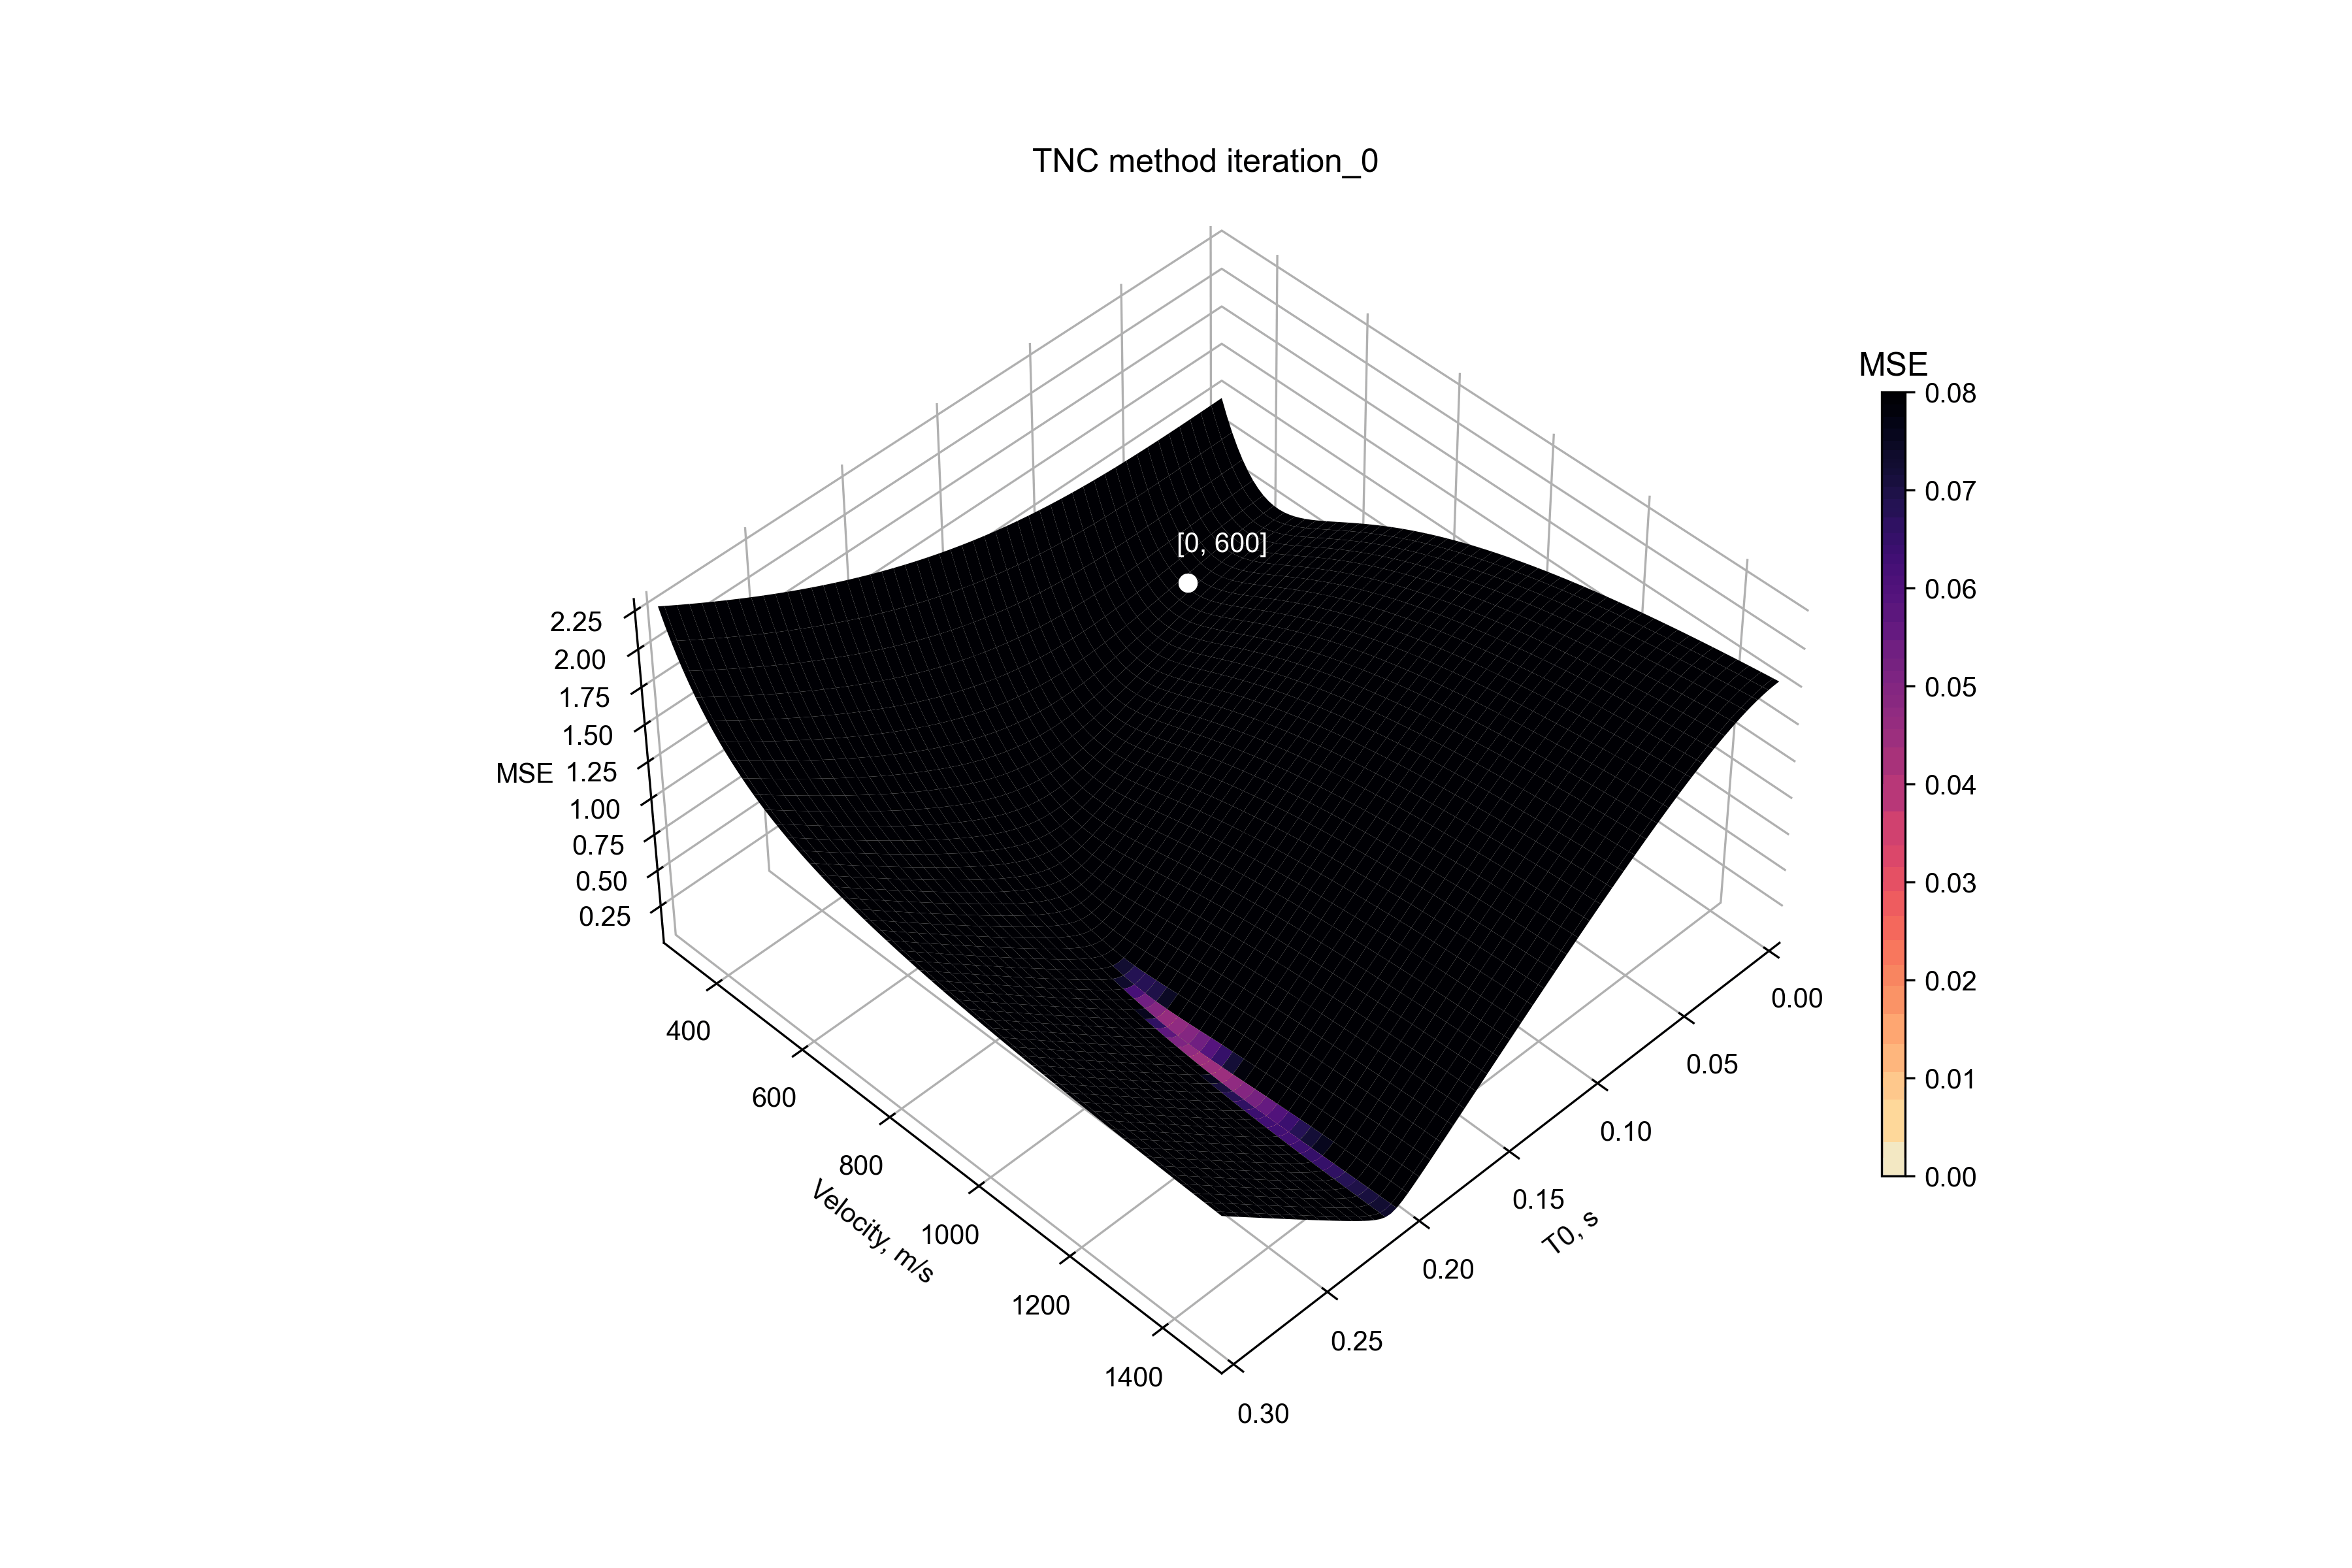

In [78]:
from IPython.display import Image
display(Image(data=open(r"/content/optimization_tnc.gif",'rb').read(), format='png'))